# Assignment 2
Import the required libraries and  load the data

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from keras.src.models import Sequential
from keras.src.layers import Input, Dense
from keras.src.datasets import california_housing
from keras.src.layers import Dropout
from keras._tf_keras.keras.regularizers import l2
from keras.src.callbacks import EarlyStopping

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='small',
                                        test_split=0.2)
print(inputs.shape, targets.shape)
print(x_test.shape, y_test.shape)

(480, 8) (480,)
(120, 8) (120,)


From the training set containing 480 samples, extract 100 samples for validation.

In [146]:
x_train = inputs[:380]
y_train = targets[:380]
x_val = inputs[380:]
y_val = targets[380:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(380, 8) (380,)
(100, 8) (100,)


Standardize the data by subtracting the mean and dividing by the standard deviation. Also divide the target values by 100 000.

In [147]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

x_val -= mean
x_val /= std

y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

Prepare two functions to plot the loss and the mean absolute error.

In [148]:
def plot_loss(history):
    plt.plot(history.history['loss'][10:], label='train loss')
    plt.plot(history.history['val_loss'][10:], label='val loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

def plot_mae(history):
    plt.plot(history.history['mae'][10:], label='train MAE')
    plt.plot(history.history['val_mae'][10:], label='val MAE')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error (in 100000 $)')

## Model 1
Model 1 consists of 4 dense layers with 32, 32, 16, and 1 neurons respectively. The model uses EarlyStopping with a patience of 10 epochs.

In [149]:
model = Sequential([
    Input(shape=(8,)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

model.compile(optimizer='adam',loss='mse',metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])


Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 6.1814 - mae: 2.1156 - val_loss: 4.3462 - val_mae: 1.6860
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6663 - mae: 1.7303 - val_loss: 3.0722 - val_mae: 1.2679
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2294 - mae: 1.3186 - val_loss: 2.1347 - val_mae: 0.8986
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2753 - mae: 0.9799 - val_loss: 1.6375 - val_mae: 0.7551
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8281 - mae: 0.8363 - val_loss: 1.5030 - val_mae: 0.7313
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6070 - mae: 0.7969 - val_loss: 1.3763 - val_mae: 0.6907
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4230 - mae: 0.7050 - val_loss: 1.2776 - val_mae: 0.6533
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4011 - mae: 0.6935 - val_loss: 1.2026 - val_mae: 0.6328
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.21

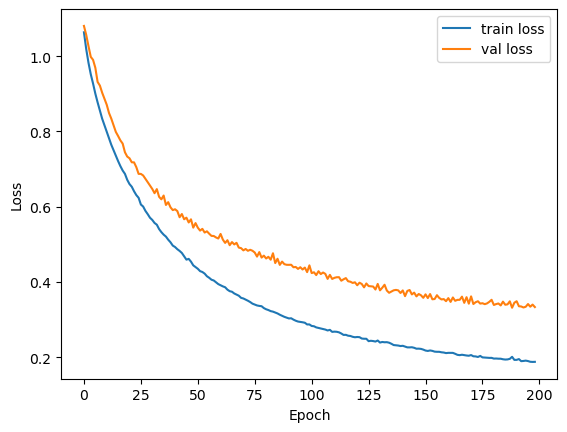

In [150]:
plot_loss(history)

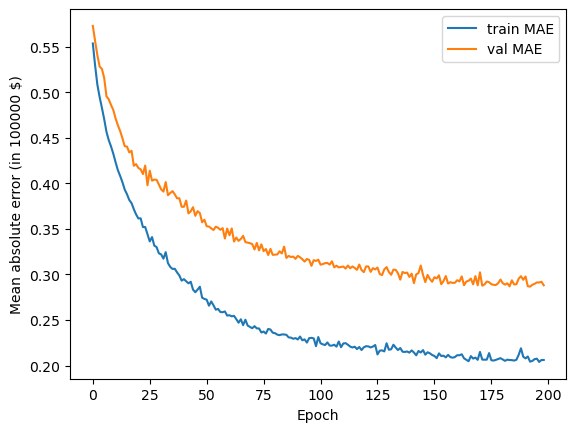

In [151]:
plot_mae(history)

Evaluate the model on the test set.

In [152]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean average error: {test_mae:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3906 - mae: 0.2889
Test mean average error: 0.2895


### Model 1 conclusion
Model 1 achieved a test MAE of 0.28 which is 0.2 lower than the original. The model was first tried with hidden layers of 128, 64 and 32 neurons, but better results were obtained with a smaller number of neurons.